In [1]:
from google.colab import files

# Subir archivo JSON
uploaded = files.upload()


Saving crypto_db.crypto_data2.json to crypto_db.crypto_data2.json


In [6]:
#Visualizamos el formato del archivo
!head -n 20 crypto_db.crypto_data2.json

[{
  "_id": {
    "$oid": "673c78c33f89a1dd8287c3fb"
  },
  "currency": "Binancecoin",
  "price": 617.17,
  "timestamp": "2024-11-19T11:38:43.122457"
},
{
  "_id": {
    "$oid": "673c78c33f89a1dd8287c3fc"
  },
  "currency": "Bitcoin",
  "price": 91659,
  "timestamp": "2024-11-19T11:38:43.144313"
},
{
  "_id": {
    "$oid": "673c78c33f89a1dd8287c3fd"
  },


In [7]:
# convertimos a formato línea por línea
import json

with open("crypto_db.crypto_data2.json", "r") as f:
    data = json.load(f)  # Carga todo el array

with open("crypto_db_fixed.json", "w") as f:
    for record in data:
        f.write(json.dumps(record) + "\n")


In [14]:
from pyspark.sql import SparkSession

# Crear la sesión de Spark
spark = SparkSession.builder \
    .appName("Crypto Data Analysis") \
    .getOrCreate()

# Ruta al archivo JSON
json_path = "crypto_db_fixed.json"

# Cargar el archivo JSON en un DataFrame
df = spark.read.json(json_path)

# Ver el esquema del DataFrame
df.printSchema()

# Mostrar las primeras 10 filas
df.show(10)


root
 |-- _id: struct (nullable = true)
 |    |-- $oid: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- price: double (nullable = true)
 |-- timestamp: string (nullable = true)

+--------------------+-----------+-------+--------------------+
|                 _id|   currency|  price|           timestamp|
+--------------------+-----------+-------+--------------------+
|{673c78c33f89a1dd...|Binancecoin| 617.17|2024-11-19T11:38:...|
|{673c78c33f89a1dd...|    Bitcoin|91659.0|2024-11-19T11:38:...|
|{673c78c33f89a1dd...|   Ethereum| 3119.0|2024-11-19T11:38:...|
|{673c78cd3f89a1dd...|Binancecoin| 617.17|2024-11-19T11:38:...|
|{673c78cd3f89a1dd...|    Bitcoin|91659.0|2024-11-19T11:38:...|
|{673c78cd3f89a1dd...|   Ethereum| 3119.0|2024-11-19T11:38:...|
|{673c78d73f89a1dd...|Binancecoin| 617.17|2024-11-19T11:39:...|
|{673c78d73f89a1dd...|    Bitcoin|91659.0|2024-11-19T11:39:...|
|{673c78d73f89a1dd...|   Ethereum| 3119.0|2024-11-19T11:39:...|
|{673c78e23f89a1dd...|Binancecoi

In [15]:
# Eliminamos el campo _id
df = df.drop("_id")
df.show(10)


+-----------+-------+--------------------+
|   currency|  price|           timestamp|
+-----------+-------+--------------------+
|Binancecoin| 617.17|2024-11-19T11:38:...|
|    Bitcoin|91659.0|2024-11-19T11:38:...|
|   Ethereum| 3119.0|2024-11-19T11:38:...|
|Binancecoin| 617.17|2024-11-19T11:38:...|
|    Bitcoin|91659.0|2024-11-19T11:38:...|
|   Ethereum| 3119.0|2024-11-19T11:38:...|
|Binancecoin| 617.17|2024-11-19T11:39:...|
|    Bitcoin|91659.0|2024-11-19T11:39:...|
|   Ethereum| 3119.0|2024-11-19T11:39:...|
|Binancecoin| 617.17|2024-11-19T11:39:...|
+-----------+-------+--------------------+
only showing top 10 rows



In [16]:
# Importación de funciones necesarias desde PySpark
from pyspark.sql.functions import date_format, hour, when

# Crear una nueva columna "8h_interval" para agrupar los datos en intervalos de 8 horas
df_8h = df.withColumn(
    "8h_interval",
    when(hour("timestamp") < 8, date_format("timestamp", "yyyy-MM-dd 00:00:00"))
    .when(hour("timestamp") < 16, date_format("timestamp", "yyyy-MM-dd 08:00:00"))
    .otherwise(date_format("timestamp", "yyyy-MM-dd 16:00:00"))
)

# Agrupar los datos por intervalos de 8 horas y la moneda
df_8h_grouped = df_8h.groupBy("8h_interval", "currency") \
    .avg("price") \
    .orderBy("8h_interval")

# Exportar los resultados a un archivo CSV
df_8h_grouped.write.csv("prices_8h.csv", header=True)

In [17]:
# combinar el archivo part-00000-* en un único archivo CSV llamado prices_8h_combined.csv
!cat prices_8h.csv/part-* > prices_8h_combined.csv

In [18]:
import pandas as pd

# Cargar el archivo combinado
data_8h = pd.read_csv("prices_8h_combined.csv", header=0)

# Verificar las primeras filas
print(data_8h.head())


           8h_interval     currency    avg(price)
0  2024-11-19 08:00:00      Bitcoin  91989.007335
1  2024-11-19 08:00:00  Binancecoin    616.939034
2  2024-11-19 08:00:00     Ethereum   3116.268215
3  2024-11-19 16:00:00      Bitcoin  92747.395079
4  2024-11-19 16:00:00     Ethereum   3113.259932


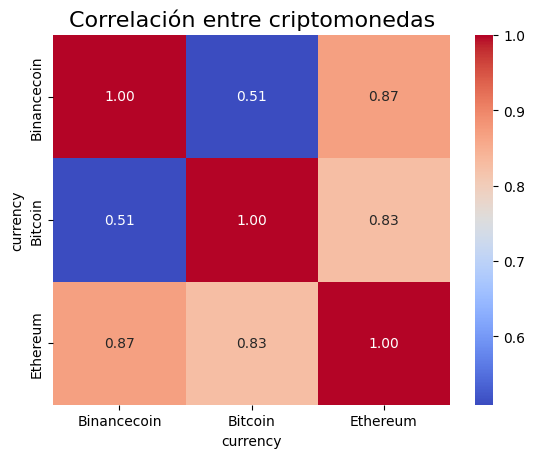

In [20]:
# tabla para calcular correlaciones
import matplotlib.pyplot as plt
import seaborn as sns

correlation_data = data_8h.pivot(index="8h_interval", columns="currency", values="avg(price)")
correlation_matrix = correlation_data.corr()

# Matriz de correlación
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlación entre criptomonedas", fontsize=16)
plt.show()



**Correlación entre Binancecoin y Ethereum (0.87)**:

La correlación es alta, lo que indica que los precios de estas dos criptomonedas tienden a moverse en la misma dirección.
Podría estar relacionado con factores del mercado que afectan ambas criptomonedas de manera similar.

**Correlación entre Bitcoin y Ethereum (0.83)**:

También es alta, lo cual es esperado, ya que Bitcoin y Ethereum son líderes del mercado y suelen estar influenciados por eventos macroeconómicos o regulatorios.

**Correlación entre Bitcoin y Binancecoin (0.51)**:

Moderada, lo que significa que Bitcoin y Binancecoin no están tan sincronizados como las otras combinaciones.
Esto puede deberse a que Binancecoin está más ligado a las actividades dentro del ecosistema de Binance, mientras que Bitcoin tiene un alcance más global.

**Valores diagonales (1.0)**:

Representan la autocorrelación de cada criptomoneda consigo misma, lo cual siempre es 1.

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_3j_f4f/53um3c5v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_3j_f4f/dnotmn1p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68660', 'data', 'file=/tmp/tmpi_3j_f4f/53um3c5v.json', 'init=/tmp/tmpi_3j_f4f/dnotmn1p.json', 'output', 'file=/tmp/tmpi_3j_f4f/prophet_modelzizjhbvl/prophet_model-20241218172730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:27:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:27:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE: 213.11577458481165
RMSE: 285.4390865333427


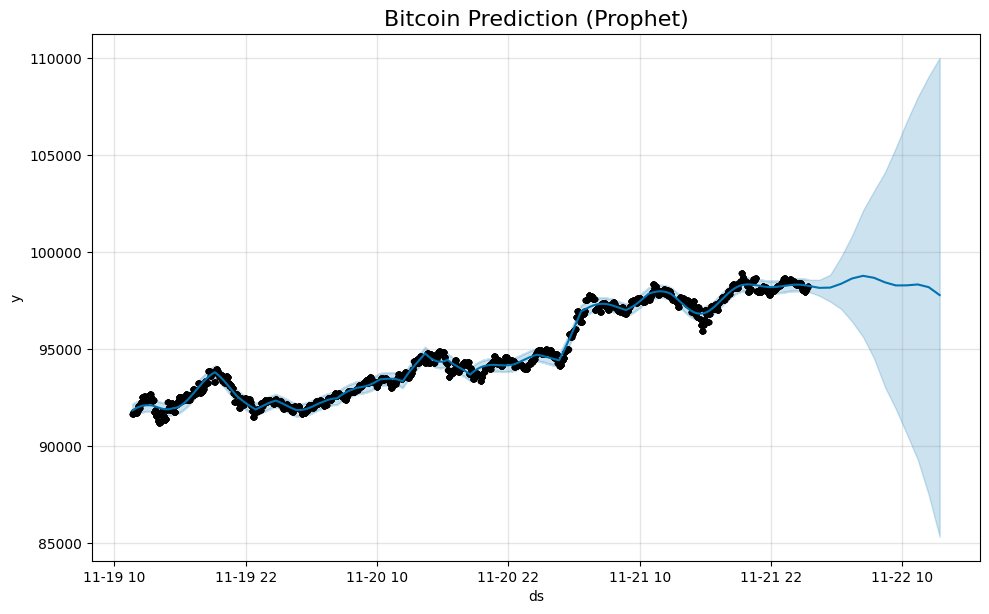

In [22]:
#Prohet Bitcoin

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Cargar los Datos de Bitcoin
from pyspark.sql.functions import to_timestamp

# Convertir la columna 'timestamp' a tipo timestamp
df = df.withColumn("timestamp", to_timestamp("timestamp"))

# Filtrar los datos de Bitcoin
bitcoin_df = df.filter(df.currency == "Bitcoin")

# Seleccionar columnas relevantes
# Se eligen las columnas "timestamp" y "price" para trabajar con los datos necesarios.
bitcoin_data = bitcoin_df.select("timestamp", "price").toPandas()

# Renombrar columnas al formato requerido por Prophet
bitcoin_data = bitcoin_data.rename(columns={"timestamp": "ds", "price": "y"})

# Dividir los datos en entrenamiento y prueba
train = bitcoin_data.iloc[:-12]  # Últimas 12 horas como prueba
test = bitcoin_data.iloc[-12:]

# Nnueva instancia del modelo
model_eval = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=True,
    changepoint_prior_scale=0.111,  # Sensibilidad ajustada
    seasonality_prior_scale=1.8  # Flexibilidad ajustada
)

# Ajustar el modelo con los datos de entrenamiento
model_eval.fit(train)

# Predicciones horizonte
future_eval = model_eval.make_future_dataframe(periods=12, freq="h")  # Predicciones a 12 horas
forecast_eval = model_eval.predict(future_eval)

# Extraer las predicciones correspondientes al conjunto de prueba
test_forecast = forecast_eval[-12:]
y_true = test['y'].values
y_pred = test_forecast['yhat'].values

# Calcular métricas de error
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# Grafico de las predicciones
fig = model_eval.plot(forecast_eval)
plt.title("Bitcoin Prediction (Prophet)", fontsize=16)
plt.show()

In [23]:
# Ethereum

# Filtrar los datos de Ethereum
ethereum_df = df.filter(df.currency == "Ethereum")

# Convertir a Pandas y preparar datos
ethereum_data = ethereum_df.select("timestamp", "price").toPandas()
ethereum_data = ethereum_data.rename(columns={"timestamp": "ds", "price": "y"})

# Dividir los datos en entrenamiento y prueba
train_eth = ethereum_data.iloc[:-12]  # Últimas 12 horas como prueba
test_eth = ethereum_data.iloc[-12:]

print("Datos preparados para Ethereum:")
print(train_eth.head())


Datos preparados para Ethereum:
                          ds       y
0 2024-11-19 11:38:43.146319  3119.0
1 2024-11-19 11:38:53.521974  3119.0
2 2024-11-19 11:39:03.926473  3119.0
3 2024-11-19 11:39:14.316416  3119.0
4 2024-11-19 11:39:24.780533  3119.0


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_3j_f4f/fk4h_697.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_3j_f4f/sd4mxkgu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80023', 'data', 'file=/tmp/tmpi_3j_f4f/fk4h_697.json', 'init=/tmp/tmpi_3j_f4f/sd4mxkgu.json', 'output', 'file=/tmp/tmpi_3j_f4f/prophet_modelub_m3io_/prophet_model-20241218173149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:31:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:31:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE para Ethereum: 196.3033141922588
RMSE para Ethereum: 208.3821774072724


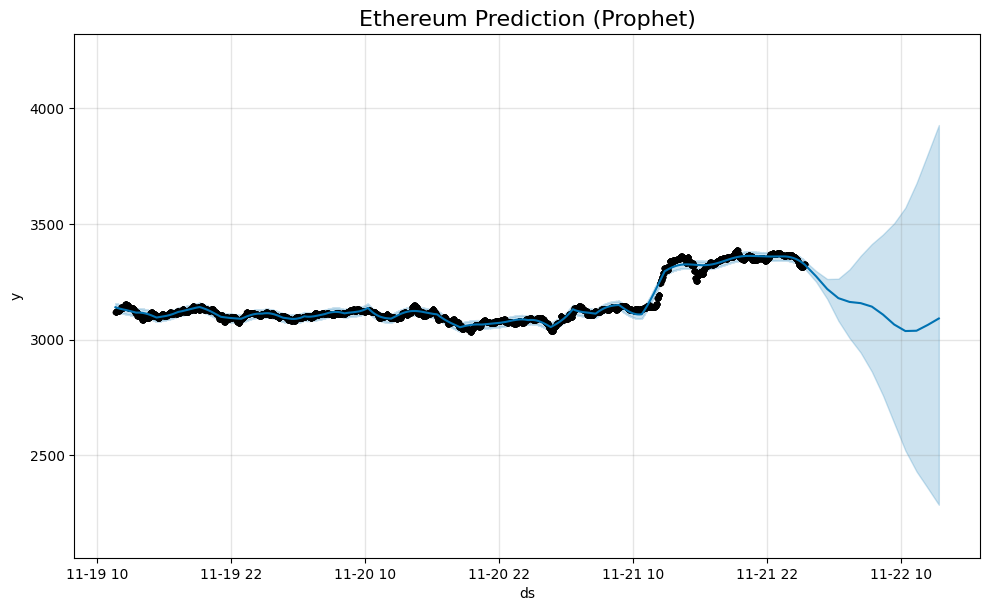

In [24]:
# Ethereum Prophet

model_eth = Prophet(
    yearly_seasonality=False,  # Sin estacionalidad anual
    weekly_seasonality=False,  # Sin estacionalidad semanal
    daily_seasonality=True,    # Con estacionalidad diaria
    changepoint_prior_scale=0.1222,      # Sensibilidad ajustada
    seasonality_prior_scale=3     # Flexibilidad más conservadora
)

# Ajustar el modelo con los datos de entrenamiento
model_eth.fit(train_eth)

# Predicciones horizonte
future_eth = model_eth.make_future_dataframe(periods=12, freq="h")  # Predicciones a 12 horas
forecast_eth = model_eth.predict(future_eth)

# Extraer las predicciones correspondientes al conjunto de prueba
test_forecast_eth = forecast_eth[-12:]
y_true_eth = test_eth['y'].values
y_pred_eth = test_forecast_eth['yhat'].values

# Calcular métricas de error
mae_eth = mean_absolute_error(y_true_eth, y_pred_eth)
rmse_eth = np.sqrt(mean_squared_error(y_true_eth, y_pred_eth))

print(f"MAE para Ethereum: {mae_eth}")
print(f"RMSE para Ethereum: {rmse_eth}")

# Grafico de las predicciones
fig_eth = model_eth.plot(forecast_eth)

# Ajustar los límites del eje Y en la gráfica
ax_eth = fig_eth.gca()  # Obtener el objeto de los ejes
y_min_eth = min(forecast_eth['yhat_lower'].min(), ethereum_data['y'].min()) * 0.9
y_max_eth = max(forecast_eth['yhat_upper'].max(), ethereum_data['y'].max()) * 1.1
ax_eth.set_ylim([y_min_eth, y_max_eth])  # Límites basados en datos históricos y predicciones
plt.title("Ethereum Prediction (Prophet)", fontsize=16)
plt.show()

In [25]:
# Binance Coin

# Filtrar los datos de Binance Coin
binancecoin_df = df.filter(df.currency == "Binancecoin")

# Convertir a Pandas y preparar datos
binancecoin_data = binancecoin_df.select("timestamp", "price").toPandas()
binancecoin_data = binancecoin_data.rename(columns={"timestamp": "ds", "price": "y"})

# Dividir los datos en entrenamiento y prueba
train_bnb = binancecoin_data.iloc[:-12]  # Últimas 12 horas como prueba
test_bnb = binancecoin_data.iloc[-12:]

print("Datos preparados para Binance Coin:")
print(train_bnb.head())

Datos preparados para Binance Coin:
                          ds       y
0 2024-11-19 11:38:43.122457  617.17
1 2024-11-19 11:38:53.519422  617.17
2 2024-11-19 11:39:03.922474  617.17
3 2024-11-19 11:39:14.313473  617.17
4 2024-11-19 11:39:24.778449  617.17


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_3j_f4f/i23mh7i5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi_3j_f4f/_qhibn3f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16442', 'data', 'file=/tmp/tmpi_3j_f4f/i23mh7i5.json', 'init=/tmp/tmpi_3j_f4f/_qhibn3f.json', 'output', 'file=/tmp/tmpi_3j_f4f/prophet_model1h82hd26/prophet_model-20241218173511.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAE para Binance Coin: 18.378149152578192
RMSE para Binance Coin: 19.722190790116493


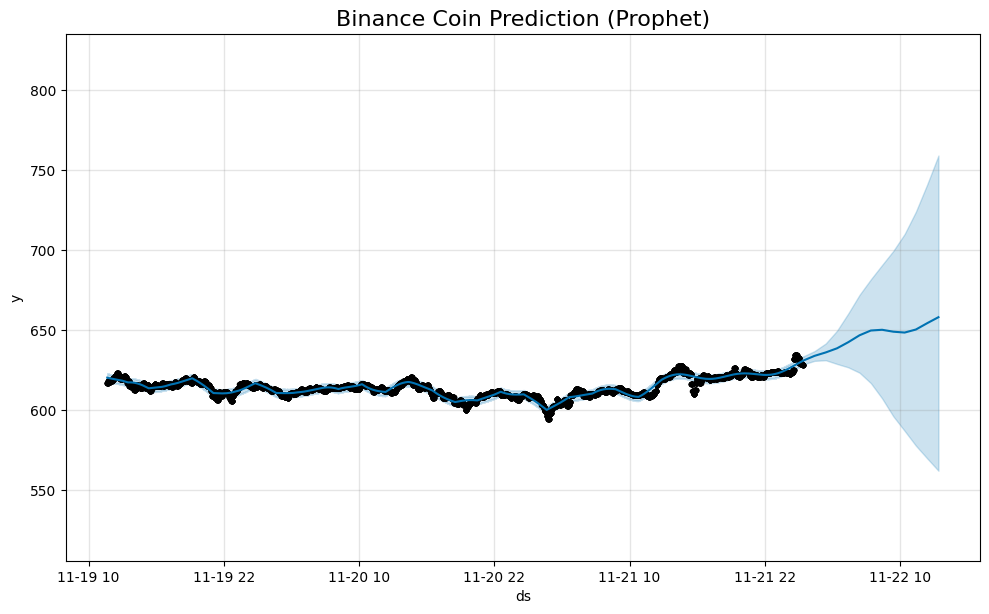

In [26]:
# Binance Coin Prophet

model_bnb = Prophet(
    yearly_seasonality=False,  # Sin estacionalidad anual
    weekly_seasonality=False,  # Sin estacionalidad semanal
    daily_seasonality=True,    # Con estacionalidad diaria
    changepoint_prior_scale=0.1,  # Sensibilidad ajustada
    seasonality_prior_scale=2.9     # Flexibilidad más conservadora
)

# Ajustar el modelo con los datos de entrenamiento
model_bnb.fit(train_bnb)

# Predicciones horizonte
future_bnb = model_bnb.make_future_dataframe(periods=12, freq="h")  # Predicciones a 12 horas
forecast_bnb = model_bnb.predict(future_bnb)

# Extraer las predicciones correspondientes al conjunto de prueba
test_forecast_bnb = forecast_bnb[-12:]
y_true_bnb = test_bnb['y'].values
y_pred_bnb = test_forecast_bnb['yhat'].values

# Calcular métricas de error
mae_bnb = mean_absolute_error(y_true_bnb, y_pred_bnb)
rmse_bnb = np.sqrt(mean_squared_error(y_true_bnb, y_pred_bnb))

print(f"MAE para Binance Coin: {mae_bnb}")
print(f"RMSE para Binance Coin: {rmse_bnb}")

# Grafico predicciones
fig_bnb = model_bnb.plot(forecast_bnb)

# Ajustar los límites del eje Y en la gráfica
ax_bnb = fig_bnb.gca()  # Obtener el objeto de los ejes
y_min_bnb = min(forecast_bnb['yhat_lower'].min(), binancecoin_data['y'].min()) * 0.9
y_max_bnb = max(forecast_bnb['yhat_upper'].max(), binancecoin_data['y'].max()) * 1.1
ax_bnb.set_ylim([y_min_bnb, y_max_bnb])  # Ajustar límites basados en datos históricos y predicciones
plt.title("Binance Coin Prediction (Prophet)", fontsize=16)
plt.show()